# Characterize DyGIE++ graph
In this notebook we'll take a first look at the graph generated on all drought and desiccation abstracts witht he PICKLE-trained DyGIE++ algorithm.

In [2]:
import jsonlines
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict, Counter
from heapq import nlargest

## Read in data

In [3]:
with jsonlines.open('../data/dygiepp/model_predictions/09Apr24_dygiepp_test_formatted_data_pickle_predictions.jsonl') as reader:
    preds = [obj for obj in reader]

## Convert to networkx graph

In [4]:
def dygiepp_to_networks(dygiepp):
    """
    Function to convert jsonlines output of dygiepp to a networkx graph

    parameters:
        dygiepp, list of dict: jsonlines prediction output

    returns:
        graph, networkx MultiDiGraph: graph
    """
    nodes = []
    edges = []
    for doc in dygiepp:
        uid = doc['doc_key']
        full_toks = [tok for sent in doc['sentences'] for tok in sent]
        for sent in doc['predicted_ner']:
            for ent in sent:
                ent_text = ' '.join(full_toks[ent[0]:ent[1]+1]).lower()
                ent_type = ent[2]
                nodes.append((ent_text, {'ent_type': ent_type}))
        for sent in doc['predicted_relations']:
            for rel in sent:
                e1 = ' '.join(full_toks[rel[0]:rel[1]+1]).lower()
                e2 = ' '.join(full_toks[rel[2]:rel[3]+1]).lower()
                rel_type = rel[4]
                edges.append((e1, e2, {'rel_type': rel_type, 'uid': uid}))
    
    # Get node counts
    node_counts = defaultdict(int)
    for node in nodes:
        node_counts[node[0]] += 1
    for node in nodes:
        node[1]['count'] = node_counts[node[0]]
  
    graph = nx.MultiDiGraph()
    _ = graph.add_nodes_from(nodes)
    _ = graph.add_edges_from(edges)
    
    return graph

In [5]:
graph = dygiepp_to_networks(preds)

## Characterize the graph

In [6]:
print(f'There are {len(graph.nodes)} nodes and {len(graph.edges)} edges in the graph.')

There are 336120 nodes and 124408 edges in the graph.


### Degree distribution

In [7]:
degs = [deg[1] for deg in list(graph.degree)]

Text(0.5, 0.98, 'Distribution of degree')

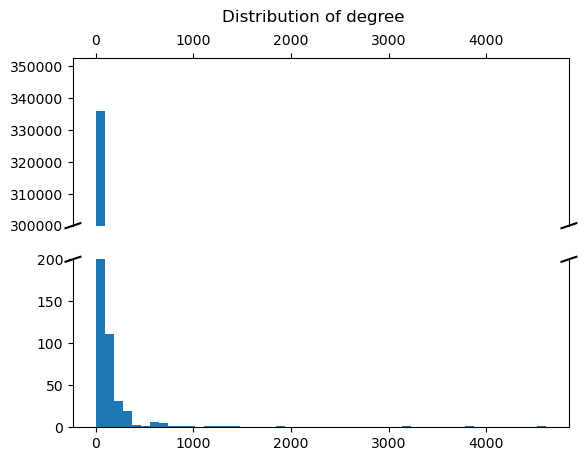

In [8]:
# Code from https://matplotlib.org/2.0.2/examples/pylab_examples/broken_axis.html
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

_ = ax1.hist(degs, bins=50)
_ = ax2.hist(degs, bins=50)

# Get max y-value
maxy = ax1.get_ylim()[1]
basemax = plt.yticks()[0][-2]

# Set the y limits
ax1.set_ylim(basemax, maxy)
ax2.set_ylim(0, 200) # Got by trial end error

# Finish formatting
ax1.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax1.xaxis.tick_top()
ax1.tick_params(labeltop='off')  # don't put tick labels at the top
ax2.xaxis.tick_bottom()

# Add the cut diagonals
d = .015  # how big to make the diagonal lines in axes coordinates
# arguments to pass to plot, just so we don't keep repeating them
kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
ax1.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
ax1.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal

fig.suptitle('Distribution of degree')

The skew here is abominable, but let's continue to characterize the graph to see what is up.

### Entity counts

In [9]:
node_counts = nx.get_node_attributes(graph, 'count')

In [10]:
res = nlargest(10, node_counts, key=node_counts.get)
print(f'The top ten most mentioned entities in our dataset are:')
for r in res:
    print(r, '--', node_counts[r])

The top ten most mentioned entities in our dataset are:
water -- 84354
aba -- 12060
salt -- 10316
n -- 8501
co2 -- 8235
wheat -- 7706
maize -- 6889
rice -- 6641
nitrogen -- 6351
chlorophyll -- 6042


Text(0.5, 0.98, 'Distribution of entity mentions')

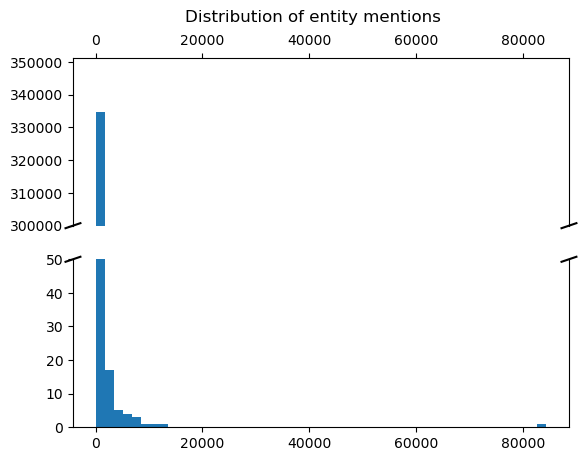

In [11]:
# Code from https://matplotlib.org/2.0.2/examples/pylab_examples/broken_axis.html
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

_ = ax1.hist(node_counts.values(), bins=50)
_ = ax2.hist(node_counts.values(), bins=50)

# Get max y-value
maxy = ax1.get_ylim()[1]
basemax = plt.yticks()[0][-2]

# Set the y limits
ax1.set_ylim(basemax, maxy)
ax2.set_ylim(0, 50) # Got by trial end error

# Finish formatting
ax1.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax1.xaxis.tick_top()
ax1.tick_params(labeltop='off')  # don't put tick labels at the top
ax2.xaxis.tick_bottom()

# Add the cut diagonals
d = .015  # how big to make the diagonal lines in axes coordinates
# arguments to pass to plot, just so we don't keep repeating them
kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
ax1.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
ax1.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal

fig.suptitle('Distribution of entity mentions')

Most nodes are only mentioned a few times.

### Entity type counts

In [12]:
ent_types = nx.get_node_attributes(graph, 'ent_type')
ent_type_counts = Counter(ent_types.values())

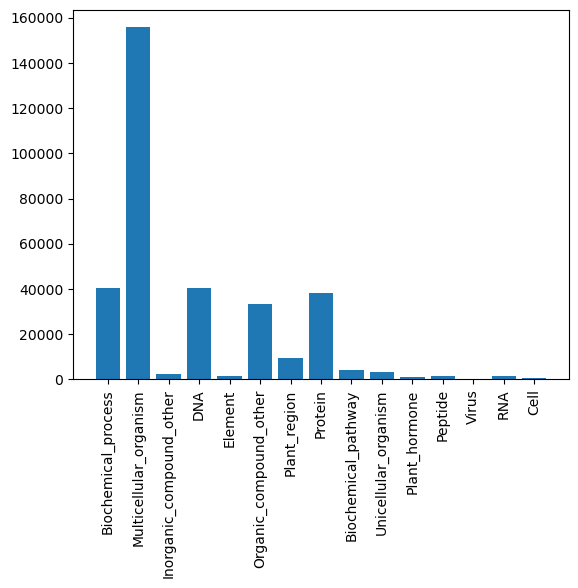

In [13]:
_ = plt.bar(ent_type_counts.keys(), ent_type_counts.values())
_ = plt.xticks(rotation=90)

### Relation type counts

In [16]:
rel_type_counts = defaultdict(int)
for e1, e2, attrs in graph.edges(data=True):
#     if e1 != 'water':
#         print(e1, '--', attrs['rel_type'], '--', e2)
    rel_type_counts[attrs['rel_type']] += 1

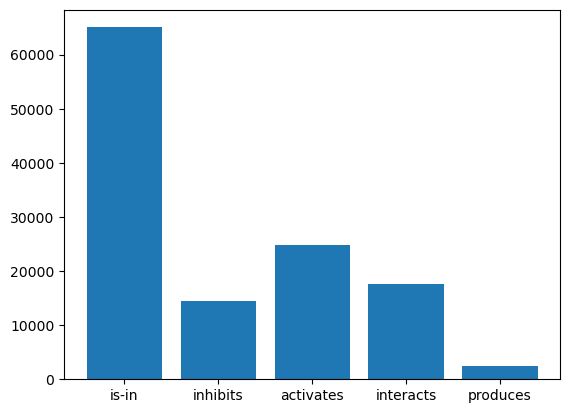

In [17]:
_ = plt.bar(rel_type_counts.keys(), rel_type_counts.values())